# Versión 2

Celda 1 – Crear estructura de carpetas (train/validation/test)

In [ ]:
# Celda 1: Crear estructura de carpetas y particiones (train/val/test)

import os
import shutil
from sklearn.model_selection import train_test_split

BASE_DIR = 'data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Clases
TRAIN_CATS_DIR = os.path.join(TRAIN_DIR, 'cats')
TRAIN_DOGS_DIR = os.path.join(TRAIN_DIR, 'dogs')
VAL_CATS_DIR = os.path.join(VAL_DIR, 'cats')
VAL_DOGS_DIR = os.path.join(VAL_DIR, 'dogs')
TEST_CATS_DIR = os.path.join(TEST_DIR, 'cats')
TEST_DOGS_DIR = os.path.join(TEST_DIR, 'dogs')

# Crear directorios
for d in [TRAIN_CATS_DIR, TRAIN_DOGS_DIR, VAL_CATS_DIR, VAL_DOGS_DIR, TEST_CATS_DIR, TEST_DOGS_DIR]:
    os.makedirs(d, exist_ok=True)

original_train_dir = 'train/'
all_filenames = os.listdir(original_train_dir)

# Separar por clase
cat_filenames = sorted([f for f in all_filenames if f.startswith('cat')])
dog_filenames = sorted([f for f in all_filenames if f.startswith('dog')])

# Usamos 8000 gatos y 8000 perros para train/val
cat_main = cat_filenames[:8000]
dog_main = dog_filenames[:8000]

# El resto se queda para test
cat_rest = cat_filenames[8000:]
dog_rest = dog_filenames[8000:]

# Train/validation split (20% validation)
train_cats, val_cats = train_test_split(cat_main, test_size=0.2, random_state=42)
train_dogs, val_dogs = train_test_split(dog_main, test_size=0.2, random_state=42)

def copy_files(filenames, source_dir, dest_dir):
    for f in filenames:
        src = os.path.join(source_dir, f)
        dst = os.path.join(dest_dir, f)
        shutil.copyfile(src, dst)

# Copiar train/validation
print("Copiando imágenes de entrenamiento...")
copy_files(train_cats, original_train_dir, TRAIN_CATS_DIR)
copy_files(train_dogs, original_train_dir, TRAIN_DOGS_DIR)

print("Copiando imágenes de validación...")
copy_files(val_cats, original_train_dir, VAL_CATS_DIR)
copy_files(val_dogs, original_train_dir, VAL_DOGS_DIR)

# Crear partición de test: 50 cats y 50 dogs no usados antes
import random
random.seed(42)

test_cats = random.sample(cat_rest, 50)
test_dogs = random.sample(dog_rest, 50)

print("Copiando imágenes de prueba (no usadas en train/val)...")
copy_files(test_cats, original_train_dir, TEST_CATS_DIR)
copy_files(test_dogs, original_train_dir, TEST_DOGS_DIR)

print("\n¡Estructura de datos lista!")
print(f"Total imágenes de entrenamiento (gatos): {len(os.listdir(TRAIN_CATS_DIR))}")
print(f"Total imágenes de entrenamiento (perros): {len(os.listdir(TRAIN_DOGS_DIR))}")
print(f"Total imágenes de validación (gatos): {len(os.listdir(VAL_CATS_DIR))}")
print(f"Total imágenes de validación (perros): {len(os.listdir(VAL_DOGS_DIR))}")
print(f"Total imágenes de prueba (gatos): {len(os.listdir(TEST_CATS_DIR))}")
print(f"Total imágenes de prueba (perros): {len(os.listdir(TEST_DOGS_DIR))}")


Copiando imágenes de entrenamiento...
Copiando imágenes de validación...
Copiando imágenes de prueba (no usadas en train/val)...

¡Estructura de datos lista!
Total imágenes de entrenamiento (gatos): 7089
Total imágenes de entrenamiento (perros): 7089
Total imágenes de validación (gatos): 2285
Total imágenes de validación (perros): 2285
Total imágenes de prueba (gatos): 50
Total imágenes de prueba (perros): 50


Celda 2 – Datasets y DataLoaders en PyTorch

In [ ]:
# Celda 2: Crear Datasets y DataLoaders con PyTorch

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Transformaciones: resize + tensor
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),   
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
print("Clases:", class_names)
print("Tamaño train:", len(train_dataset))
print("Tamaño validación:", len(val_dataset))
print("Tamaño test:", len(test_dataset))


Clases: ['cats', 'dogs']
Tamaño train: 14178
Tamaño validación: 4570
Tamaño test: 100


Celda 3 – Definir la CNN en PyTorch

In [ ]:
# Celda 3: Definir el modelo CNN en PyTorch

import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

class DogsCatsCNN(nn.Module):
    def __init__(self):
        super(DogsCatsCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout(0.25)

        # Calcular tamaño del feature map después de 3 pools
        self.flatten_dim = 128 * 18 * 18

        self.fc1 = nn.Linear(self.flatten_dim, 512)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)  # salida binaria

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout_conv(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)  

        return x

model = DogsCatsCNN().to(device)
print(model)


Usando dispositivo: cuda
DogsCatsCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=41472, out_features=512, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


Celda 4 – Entrenamiento del modelo

In [ ]:
# Celda 4: Entrenamiento del modelo

import torch.optim as optim
import torch

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 30

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

def calculate_accuracy(logits, labels):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).long()
    correct = (preds.view(-1) == labels.view(-1)).sum().item()
    total = labels.size(0)
    return correct / total

for epoch in range(EPOCHS):
    # Entrenamiento 
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)  
        loss = criterion(outputs, labels.float())

        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        running_acc += calculate_accuracy(outputs, labels) * batch_size
        total_train += batch_size

    epoch_train_loss = running_loss / total_train
    epoch_train_acc = running_acc / total_train

    # Validación
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels.float())

            batch_size = labels.size(0)
            val_loss += loss.item() * batch_size
            val_acc += calculate_accuracy(outputs, labels) * batch_size
            total_val += batch_size

    epoch_val_loss = val_loss / total_val
    epoch_val_acc = val_acc / total_val

    history["train_loss"].append(epoch_train_loss)
    history["val_loss"].append(epoch_val_loss)
    history["train_acc"].append(epoch_train_acc)
    history["val_acc"].append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f} - "
          f"Val loss: {epoch_val_loss:.4f}, Val acc: {epoch_val_acc:.4f}")

print("\n¡Entrenamiento completado!")


Epoch 1/30 - Train loss: 0.6477, Train acc: 0.6152 - Val loss: 0.5868, Val acc: 0.6930
Epoch 2/30 - Train loss: 0.5652, Train acc: 0.7141 - Val loss: 0.5248, Val acc: 0.7385
Epoch 3/30 - Train loss: 0.5184, Train acc: 0.7455 - Val loss: 0.4958, Val acc: 0.7516
Epoch 4/30 - Train loss: 0.4889, Train acc: 0.7591 - Val loss: 0.4730, Val acc: 0.7698
Epoch 5/30 - Train loss: 0.4628, Train acc: 0.7776 - Val loss: 0.4698, Val acc: 0.7733
Epoch 6/30 - Train loss: 0.4439, Train acc: 0.7895 - Val loss: 0.4557, Val acc: 0.7858
Epoch 7/30 - Train loss: 0.4175, Train acc: 0.8075 - Val loss: 0.4369, Val acc: 0.7902
Epoch 8/30 - Train loss: 0.4051, Train acc: 0.8114 - Val loss: 0.4091, Val acc: 0.8136
Epoch 9/30 - Train loss: 0.3938, Train acc: 0.8232 - Val loss: 0.3839, Val acc: 0.8289
Epoch 10/30 - Train loss: 0.3725, Train acc: 0.8331 - Val loss: 0.3638, Val acc: 0.8389
Epoch 11/30 - Train loss: 0.3602, Train acc: 0.8401 - Val loss: 0.3642, Val acc: 0.8376
Epoch 12/30 - Train loss: 0.3428, Train a

Celda 5 – Gráficas de loss y accuracy

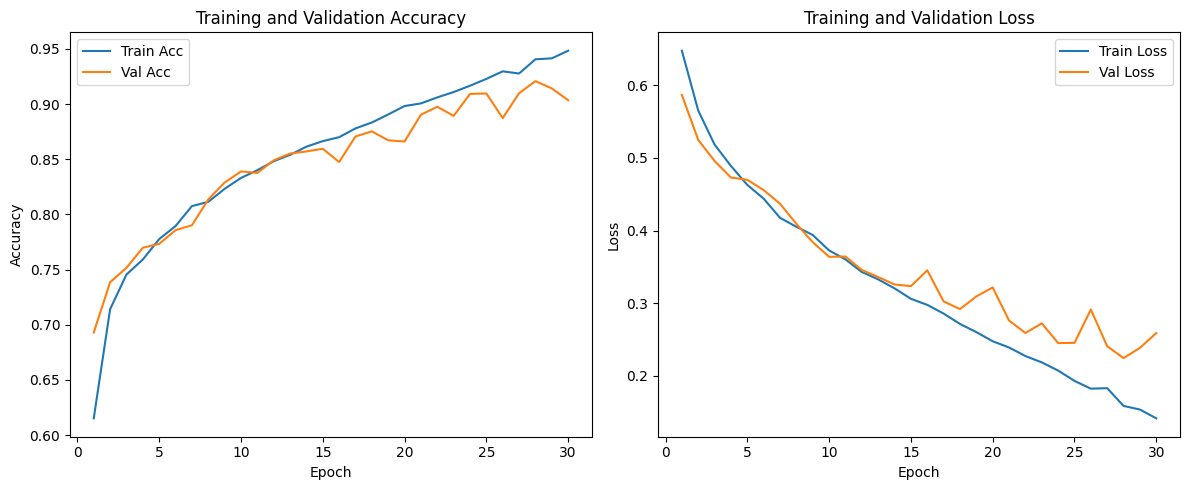

In [ ]:
# Celda 5: Gráficas de entrenamiento y validación

import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_acc"], label='Train Acc')
plt.plot(epochs_range, history["val_acc"], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_loss"], label='Train Loss')
plt.plot(epochs_range, history["val_loss"], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Celda 6 – Matriz de confusión 

Matriz de confusión (filas = verdaderas, columnas = predichas):
[[46  4]
 [13 37]]

Reporte de clasificación:
              precision    recall  f1-score   support

        cats       0.78      0.92      0.84        50
        dogs       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



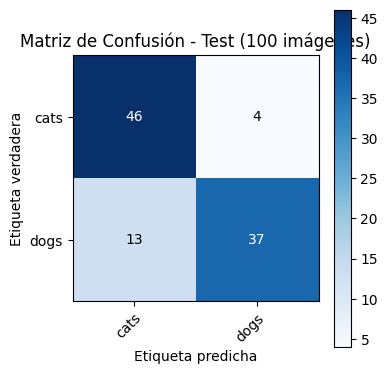

In [ ]:
# Celda 6: Matriz de confusión en 100 imágenes no usadas 

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).squeeze(1)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

cm = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión (filas = verdaderas, columnas = predichas):")
print(cm)

print("\nReporte de clasificación:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Visualización bonita de la matriz
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names, yticklabels=class_names,
    ylabel='Etiqueta verdadera',
    xlabel='Etiqueta predicha',
    title='Matriz de Confusión - Test (100 imágenes)'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Anotar valores
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


Celda 7 – Guardar el modelo entrenado

In [ ]:
# Celda 7: Guardar el modelo entrenado

model_filename = 'clasificador_perros_gatos_v2.pth'
torch.save(model.state_dict(), model_filename)
print(f"¡Modelo guardado como: {model_filename}!")


¡Modelo guardado como: clasificador_perros_gatos_v2.pth!
